## 4-2. OneHotEncoding 와 ColumnTransformer: scikit-learn으로 범주형 변수 다루기
- 이전에 언급한 것처럼 scikit-learn은 원-핫-인코딩을 수행할 수 있음
- scikit-learn은 훈련 세트와 테스트 세트를 같은 방식으로 다루기 쉬운 것이 장점
- 원-핫-인코딩은 OneHotEncoder 클래스에 구현되어 있음
- OneHotEncoding는 모든 열에 인코딩을 수행

In [77]:
from sklearn.preprocessing import OneHotEncoder
import os
import mglearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

demo_df = pd.DataFrame({"숫자 특성": [0, 1, 2, 1], "범주형 특성": ["양말", "여우", "양말", "상자"]})
demo_df
pd.get_dummies(demo_df)
demo_df["숫자 특성"] = demo_df["숫자 특성"].astype(str)
pd.get_dummies(demo_df, columns=["숫자 특성", "범주형 특성"])


# sparse=False로 설정하면 OneHotEncoding가 희소 행렬이 아니라 넘파이 배열을 반환
ohe = OneHotEncoder(sparse=False)
print(ohe.fit_transform(demo_df))

[[1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0.]]


c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


- 문자열 특성과 정수 특성이 모두 변환되었음
- scikit-learn의 출력은 DataFrame이 아니기 때문에 열 이름이 없음
- 변환된 특성에 해당하는 원본 범주형 변수 이름을 얻으려면 get_feature_names_out 메서드를 사용

In [78]:
print(ohe.get_feature_names_out())

['숫자 특성_0' '숫자 특성_1' '숫자 특성_2' '범주형 특성_상자' '범주형 특성_양말' '범주형 특성_여우']


- 처음 세 개의 열은 첫 번째 원본 특성의 값 0, 1, 2에 해당
- 대부분의 애플리케이션에서 일부 특성은 범주형이고 일부는 연속형
- OneHotEncoder는 모든 특성을 범주형이라고 가정하기 때문에 바로 적용할 수는 없음
- ColumnTransformer 클래스가 필요한 이유가 여기에 있음
- 이 클래스는 입력 데이터에 있는 열마다 다른 변환을 적용할 수 있음
- 연속형 특성과 범주형 특성은 매우 다른 종류의 전처리 과정이 필요하기 때문에 이 클래스가 매우 유용

In [79]:
data = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "adult.data"), header=None, index_col=False, names=["age", "workclass", "fnlwgt", "education", "education-num", "matrial-status", "occupation", "relationship", "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"])
# 예제를 위해 몇 개의 열만 선택
data = data[["age", "workclass", "education", "gender", "hours-per-week", "occupation", "income"]]
data.head()

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


- 이 데이터셋에 선형 모델을 적용하여 소득을 예측하려면 범주형 변수에 원-핫-인코딩을 적용하는 것 외에 연속형 변수인 age와 hours-per-week의 스케일도 조정해야 함
- 여기에 ColumnTransformer가 필요. 각 열의 변환은 이름, 변환기 객체, 이 변환이 적용될 열을 지정
- 열은 열 이름이나 정수 인덱스, 불리언 마스크(Boolean mask)로 선택할 수 있음
- 해당 열에 변환이 적용된 후 변환 결과가 (옆으로 나란히) 합쳐짐. 앞선 예에서 열 이름을 사용하면 다음과 같음

In [80]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer([("scaling", StandardScaler(), ['age', 'hours-per-week']), ("onehot", OneHotEncoder(sparse_output=False), ['workclass', 'education', 'gender', 'occupation'])])

- 다른 scikit-learn 변환기와 동일하게 ColumnTransformer 객체의 fit, transform 메서드를 사용할 수 있음
- 이전처럼 선형 모델을 만듦. 연속형 변수의 스케일을 조정
- train_test_split 함수에 넘파이 배열 대신에 특성을 포함하고 있는 DataFrame을 전달할 수 있음
- 이렇게 하면 ColumnTransformer에 필요한 열 이름을 보존할 수 있음

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# income을 제외한 모든 열을 추출
data_features = data.drop("income", axis=1)
# 데이터프레임과 income을 분할
X_train, X_test, y_train, y_test = train_test_split(data_features, data.income, random_state=0)

ct.fit(X_train)
X_train_trans = ct.transform(X_train)
print(X_train_trans.shape)

(24420, 44)


- pd.get_dummies를 사용했을 때와 마찬가지로 44개의 특성이 만들어졌음
- 연속형 특성을 스케일 조정했다는 것만 다름

In [82]:
# LogisticRegression 모델을 만듦
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_trans, y_train)

X_test_trans = ct.transform(X_test)
print("테스트 점수: {:.2f}".format(logreg.score(X_test_trans, y_test)))

테스트 점수: 0.81


- 이 경우에 데이터의 스케일이 영향을 미치지 못함
- 하나의 변환기로 모든 전처리 단계를 캡슐화하면 장점이 더 있음
- ColumnTransformer 안의 단계에 접근하려면 named_transformers_ 속성을 사용

In [83]:
ct.named_transformers_.onehot

OneHotEncoder(sparse_output=False)

## 4-3. make_column_transformer로 간편하게 ColumnTransformer 만들기
- ColumnTransformer를 만들면 조금 번거로울 때가 있음
- 각 단계 이름을 일일이 지정할 필요가 없는 경우가 많음
- 클래스 이름을 기반으로 자동으로 각 단계에 이름을 붙여주는 편리한 함수(make_column_transformer)가 있음

In [84]:
# make_column_transformer 함수의 사용범은 다음과 같음
from sklearn.compose import make_column_transformer
ct = make_column_transformer((StandardScaler(), ["age", "hours-per-week"]), (OneHotEncoder(sparse=False), ["workclass", "education", "gender", "occupation"]))

## 4-4. 구간 분할, 이산화 그리고 선형 모델, 트리 모델
- 데이터를 가장 잘 표현하는 방법은 데이터가 가진 의미뿐 아니라 어떤 모델을 사용하는지에 따라 다름
- 아주 폭넓게 사용하는 두 알고리즘은 선형 모델과 트리 기반 모델(결정 트리, 그레이디언트 부스팅 트리, 랜덤 포레스트 등)은 특성의 표현 방식으로 인해 미치는 영향이 매우 다름
- wave 데이터셋 사용. 이 데이터에는 입력 특성이 하나뿐. 이 데이터셋을 이용해 선형 회귀 모델과 결정 트리 회귀를 비교

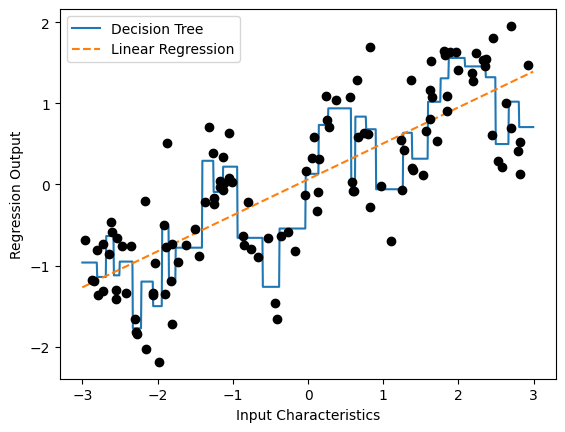

In [85]:
# wave 데이터셋에 적용한 선형 회귀와 결정 트리의 비교
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = mglearn.datasets.make_wave(n_samples=120)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X, y)
plt.plot(line, reg.predict(line), label="Decision Tree")

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), "--", label="Linear Regression")
plt.plot(X[:, 0], y, "o", c="k")
plt.xlabel("Input Characteristics")
plt.ylabel("Regression Output")
plt.legend(loc="best");

- 선형 모델은 선형 관계로만 모델링하므로 특성이 하나일 땐 직선으로 나타남
- 결정 트리는 이 데이터로 훨씬 복잡한 모델을 만들 수 있으나, 이는 데이터의 표현 형태에 따라 굉장히 달라짐
- 연속형 데이터에 아주 강력한 선형 모델을 만드는 방법 하나는 한 특성을 여러 특성으로 나누는 구간 분한(bining)임 (이산화라고도 함)
- 이 특성의 입력값 범위(여기서는 -3 ~ 3)가 나뉘어 여러 구간으로, 예를 들면 10갸로 되어 있다고 생각
- 그럼 각 데이터 포인트가 어떤 구간에 속하는지로 나타낼 수 있음
- 구간의 경계를 정의하는 데는 여러 방법이 있음
- 예를 들어 균일한 너비로 (즉 구간의 경계 간의 거리가 동일하게) 하거나 데이터의 분위를 사용할 수 있음 (즉, 데이터가 많은 구간은 좁아짐)
- KBinsDiscretizer 클레스에 이런 방법들이 구현되어 있음

In [86]:
from sklearn.preprocessing import KBinsDiscretizer
kb = KBinsDiscretizer(n_bins=10, strategy="uniform")
kb.fit(X)
print("bin edges: \n", kb.bin_edges_)

bin edges: 
 [array([-2.9668673 , -2.37804841, -1.78922951, -1.20041062, -0.61159173,
        -0.02277284,  0.56604605,  1.15486494,  1.74368384,  2.33250273,
         2.92132162])                                                   ]


c:\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


- 첫 번째 구간은 특성의 값이 -2.967(데이터에서 가장 작은 값)부터 -2.378까지 모든 데이터 포인트를 담음
- 두 번째 구간은 -2.378부터 -1.789 사이인 모든 데이터 포인트를 포함하고, 이런 식으로 계속됨
- KBinsDiscretizer는 한 번에 여러 개의 특성에 적용할 수 있음
- bin_edges_는 특성별로 경곗값이 저장되어 있고, 이 경우에는 길이가 1인 배열이 출력됨
- transform 메서드를 사용하면 각 데이터 포인트를 해당되는 구간으로 인코딩할 수 있음
- 기본적으로 KBinsDiscretizer는 구간에 원-핫-인코딩을 적용
- 구간마다 하나의 새로운 특성이 생기므로 희소 행렬을 만듦
- 10개의 구간을 지정했기 때문에 변환된 데이터는 10차원임

In [87]:
X_binned = kb.transform(X)
X_binned

<120x10 sparse matrix of type '<class 'numpy.float64'>'
	with 120 stored elements in Compressed Sparse Row format>

In [88]:
# 희소 행렬을 밀집 배열로 변환하여 원본 데이터 포인트와 인코딩 결과를 비교
print(X[:10])
X_binned.toarray()[:10]

[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]
 [-2.06403288]
 [-2.65149833]
 [ 2.19705687]
 [ 0.60669007]
 [ 1.24843547]]


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

- 첫 번째 데이터 포인트 -0.753이 네 번째 구간에 들어갔음
- 두 번째 데이터 포인트 2.704는 열 번째 구간에 포함되고, 이런 식으로 계속됨
- 여기에서 wave 데이터셋에 있는 연속형 특성을 각 데이터 포인트가 어느 구간에 속했는지 원-핫-인코딩한 범주형 특성으로 변환
- encode='ordinal'로 설정하면 원-핫-인코딩된 구간의 인덱스를 바로 계산할 수 있지만 유용하지는 않음
- 예제를 간단하게 만들기위해 encode='onehot-dense'로 지정하여 원-핫-인코딩된 밀집 배열을 만들고, 그러면 모든 특성을 바로 출력할 수 있음

c:\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


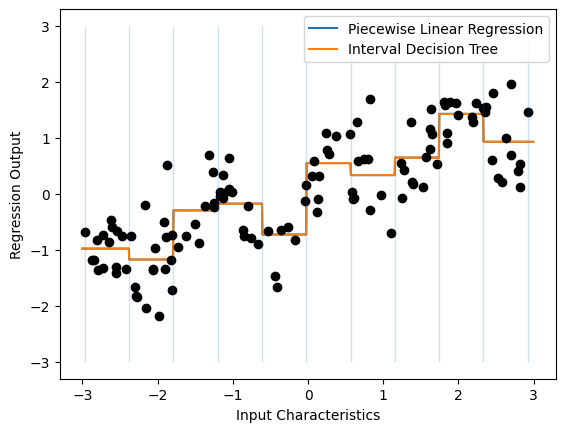

In [89]:
# 구간으로 나뉜 특성에 적용한 선형 회귀와 결정 트리 회귀의 비교
kb = KBinsDiscretizer(n_bins=10, strategy="uniform", encode="onehot-dense")
kb.fit(X)
X_binned = kb.transform(X)
line_binned = kb.transform(line)

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label="Piecewise Linear Regression")

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label="Interval Decision Tree")
plt.plot(X[:, 0], y, "o", c="k")
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=0.2)
plt.legend(loc="best")
plt.xlabel("Input Characteristics")
plt.ylabel("Regression Output");

- 선형 회귀 모델과 결정 트리가 같은 예측을 만들어내서 파선과 실선이 완전히 겹쳐졌음
- 구간별로 이 두 모델이 예측한 것은 상숫값
- 각 구간 안에서는 특성이 값이 상수이므로, 어떤 모델이든 그 구간의 포인트에 대해서는 같은 값을 예측할 것
- 구간으로 나눈 특성을 사용하기 전과 비교해보면, 각 구간에서 다른 값을 가지고 있으므로 선형 모델이 훨씬 유연해진 것을 알 수 있음
- 반면에 결정 트리는 덜 유연해졌음
- 트리 모델은 데이터를 자유롭게 나눠 학습할 수 있으므로 특성의 값을 구간으로 나누는 것이 아무런 득이 되지 않음
- 다르게 생각하면 결정 트리는 데이터셋에서 예측을 위한 가장 좋은 구간을 학습한다고 볼 수 있음
- 거기다가 구간 나누기는 특성마다 따로 해야 하지만, 결정 트리는 한 번에 여러 특성을 살필 수 있으나, 선형 모델은 이런 변환으로부터 큰 이득을 얻었음
- 일부 특성과 출력이 비선형 관계이지만, 용량이 매우 크고 고차원 데이터셋이라 선형 모델을 사용해야 한다면 구간 분할이 모델 성능을 높이는 데 아주 좋은 방법이 될 수 있음

## 4-5. 상호작용과 다항식
- 특별히 특성을 풍부하게 나타내는 또 하나의 방법은 원본 데이터에 상호작용(Interaction)과 다항식(Polynomial)을 추가하는 것
- 이런 종류의 특성 공학은 통계적 모델링에서 자주 사용하지만 일반적인 머신러닝 애플리케이션에도 많이 적용함
- 선형 모델은 wave 데이터셋의 각 구간에 대해 상숫값을 학습했음
- 그런데 선형 모델은 이런 절편 외에도 기울기도 학습할 수 있음
- 선형 모델에 기울기를 추가하는 방법은 구간으로 분할된 데이터에 원래 특성(이 그림에서 x축)을 다시 추가하는 것
- 이렇게 하면 11차원 데이터셋이 만들어짐

In [90]:
X_combined = np.hstack([X, X_binned])
print(X_combined.shape)

(120, 11)


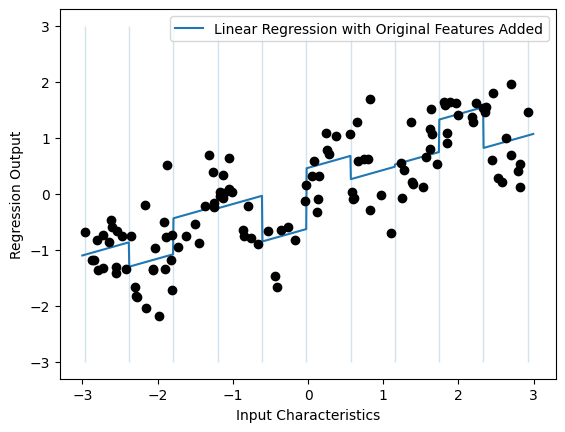

In [91]:
# 구간으로 분할된 특성과 하나의 기울기를 사용한 선형 회귀
reg = LinearRegression().fit(X_combined, y)

line_combined = np.hstack([line, line_binned])
plt.plot(line, reg.predict(line_combined), label="Linear Regression with Original Features Added")

plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=0.2)
plt.legend(loc="best")
plt.xlabel("Input Characteristics")
plt.ylabel("Regression Output")
plt.plot(X[:, 0], y, "o", c="k");

- 이 예에서 이 모델은 각 구간의 절편과 기울기를 학습했음
- 학습된 기울기는 양수이고 모든 구가넹 걸쳐 동일하고, x축 특성이 하나이므로 기울기도 하나임
- 기울기가 모든 구간에서 같으니 별로 유익해 보이지 않음
- 오히려 각 구간에서 다른 기울기를 가지는 게 좋을 것 같습니다! 이런 효과를 위해서 데이터 포인트가 있는 구간과 x축 사이의 상호작용 특성을 추가할 수 있음
- 이 특성이 구간 특성과 원본 특성의 곱

In [92]:
X_product = np.hstack([X_binned, X * X_binned])
print(X_product.shape)

(120, 20)


- 데이터셋은 이제 데이터 포인트가 속한 구간과 이 구간에 원본 특성을 곱한 값을 더해 20개의 특성을 가짐
- 이 곱셈 특성을 각 구간에 대한 x축 특성의 복사본이라고 생각할 수 있음
- 즉 이 값은 구간 안에서는 원본 특성이고 다른 곳에서는 0임

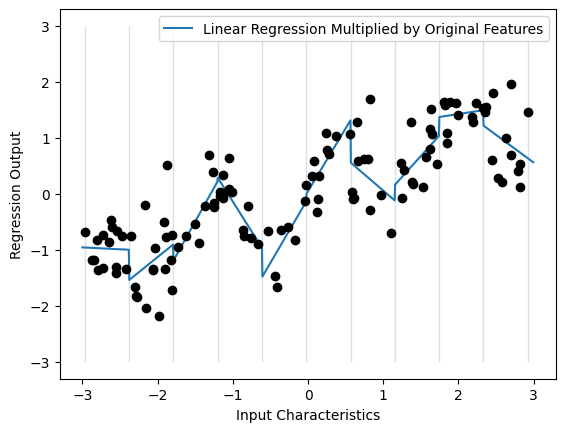

In [96]:
# 이 데이터를 사용해 만든 선형 모델의 결과
# 구간별 기울기가 다른 선형 회귀
reg = LinearRegression().fit(X_product, y)

line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, reg.predict(line_product), label="Linear Regression Multiplied by Original Features")

plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=0.2)

plt.plot(X[:, 0], y, "o", c="k")
plt.xlabel("Input Characteristics")
plt.ylabel("Regression Output")
plt.legend(loc="best");

- 그림에서 볼 수 있듯이 이 모델에서는 각 구간에서 절편과 기울기가 모두 다름
- 구간 나누기는 연속형 특성을 확장하는 방법 중 하나
- 원본 특성의 다항식을 추가하는 방법도 있음
- 특성 x가 주어지면 x ** 2, x ** 3, x ** 4 등을 시도해볼 수 있음
- 이 방식이 preprocessing 모듈의 PolynomialFeatures에 구현되어 있음

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
# x ** 10까지 고차항을 추가
